# Smart Waterways Berlin - Shoreline Extraction & Water Analysis
## Müggelsee Case Study

This notebook performs shoreline extraction and water body separation using Sentinel-2 satellite imagery for the Müggelsee area.

## Cell 1: Installation & Imports

In [ ]:
from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("35CszcfhrcPu9EfrBJtB9XJzdbg_2VtxrffPXrL4mXm2aAKCQ")

# Now connect to port 8888
public_url = ngrok.connect(8888)
print(f"Jupyter URL: {public_url}")


Jupyter URL: NgrokTunnel: "https://gablelike-lissotrichous-latrina.ngrok-free.dev" -> "http://localhost:8888"


In [ ]:
!pip install vscode-colab
import vscode_colab
vscode_colab.login()


2025-11-08 17:56:30 | INFO     | vscode_colab.server:download_vscode_cli:74 - Downloading VS Code CLI (cli-alpine-x64) to /content/vscode_cli_alpine_x64.tar.gz...
2025-11-08 17:56:32 | INFO     | vscode_colab.server:download_vscode_cli:87 - VS Code CLI tarball downloaded. Extracting...
2025-11-08 17:56:32 | INFO     | vscode_colab.server:download_vscode_cli:171 - VS Code CLI setup successful. Executable at: '/content/code'.
2025-11-08 17:56:32 | INFO     | vscode_colab.server:_login:220 - Initiating VS Code Tunnel login with command: /content/code tunnel user login --provider github
2025-11-08 17:56:32 | INFO     | vscode_colab.server:_login:254 - Monitoring login process output for GitHub authentication URL and code...
2025-11-08 17:56:32 | INFO     | vscode_colab.server:_login:272 - Detected authentication URL: https://github.com/login/device
2025-11-08 17:56:32 | INFO     | vscode_colab.server:_login:278 - Detected authentication code: 5EB4-214D
2025-11-08 17:56:32 | INFO     | vsco

2025-11-08 17:56:32 | INFO     | vscode_colab.server:login:200 - Login successful: Set environment variable VSCODE_COLAB_LOGGED_IN=true


True

In [ ]:
vscode_colab.connect()

2025-11-08 17:57:26 | INFO     | vscode_colab.server:connect:579 - Initial CWD for connect operation: /content
2025-11-08 17:57:26 | INFO     | vscode_colab.server:download_vscode_cli:58 - VS Code CLI already exists and is executable at /content/code. Skipping download.
2025-11-08 17:57:26 | INFO     | vscode_colab.server:_launch_and_monitor_tunnel:457 - Starting VS Code tunnel with command: /content/code tunnel --accept-server-license-terms --name colab --install-extension mgesbert.python-path --install-extension ms-python.black-formatter --install-extension ms-python.debugpy --install-extension ms-python.isort --install-extension ms-python.python --install-extension ms-python.vscode-pylance --install-extension ms-toolsai.jupyter --install-extension ms-toolsai.jupyter-keymap --install-extension ms-toolsai.jupyter-renderers --install-extension ms-toolsai.tensorboard
2025-11-08 17:57:26 | INFO     | vscode_colab.server:_launch_and_monitor_tunnel:458 - Tunnel will run with CWD: /content


2025-11-08 17:57:38 | INFO     | vscode_colab.server:connect:627 - VS Code tunnel 'colab' process started successfully.


<Popen: returncode: None args: ['/content/code', 'tunnel', '--accept-server-...>

In [11]:
%pip install sentinelhub
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install geopandas
%pip install scipy
%pip install scikit-image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry import box
import warnings
warnings.filterwarnings('ignore')

# Sentinel Hub imports
from sentinelhub import (
    SentinelHubRequest,
    SHConfig,
    DataCollection,
    bbox_to_dimensions,
    CRS,
    BBox,
    MimeType,
    SentinelHubCatalog,
    Geometry
)
# from sentinelhub.api.request import ResponseType # Removed this line

# Image processing imports
from scipy import ndimage
from skimage import exposure, filters
import json
from datetime import datetime, timedelta
import getpass

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Cell 2: Sentinel Hub Configuration

Only run this cell if you have not created a configuration.

In [12]:
# Check if config already exists
try:
    config = SHConfig("cdse")
    print("✓ Loaded existing CDSE configuration")
except:
    print("Creating new CDSE configuration...")
    config = SHConfig()
    config.sh_client_id = getpass.getpass("Enter your SentinelHub client id: ")
    config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret: ")
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save("cdse")
    print("✓ Configuration saved as 'cdse'")

# Load the saved configuration
config = SHConfig("cdse")
print("✓ Ready to query Sentinel Hub")

Creating new CDSE configuration...
Enter your SentinelHub client id: ··········
Enter your SentinelHub client secret: ··········
✓ Configuration saved as 'cdse'
✓ Ready to query Sentinel Hub


## Cell 3: Define Area of Interest - Müggelsee

In [13]:
# Müggelsee area coordinates (WGS84: min_lon, min_lat, max_lon, max_lat)
aoi_coords_wgs84 = [13.552322, 52.399591, 13.799515, 52.485394]

# Create BBox object
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)

# Calculate image dimensions (10m resolution)
resolution = 10  # meters per pixel
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Area of Interest: Müggelsee")
print(f"Coordinates: {aoi_coords_wgs84}")
print(f"BBox: {aoi_bbox}")
print(f"Resolution: {resolution}m/pixel")
print(f"Image dimensions: {aoi_size}")

Area of Interest: Müggelsee
Coordinates: [13.552322, 52.399591, 13.799515, 52.485394]
BBox: 13.552322,52.399591,13.799515,52.485394
Resolution: 10m/pixel
Image dimensions: (1698, 924)


## Cell 4: Define Shoreline Extraction EvalScript

In [14]:
# Shoreline extraction and water body separation evalscript
shoreline_evalscript = """
//VERSION=3
// Shoreline Extraction & Water Body Separation
// Smart Waterways Berlin - Enhanced Shore Detection

function setup() {
  return {
    input: [{
      bands: [
        "B02",  // Blue
        "B03",  // Green
        "B04",  // Red
        "B05",  // Vegetation Red Edge
        "B08",  // NIR
        "B11",  // SWIR
        "SCL",  // Scene Classification Layer
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  };
}

function evaluatePixel(sample) {
  // Cloud & shadow filtering
  let scl = sample.SCL;
  let isCloud = (scl === 8 || scl === 9 || scl === 10);
  let isShadow = (scl === 3 || scl === 2);
  let isSnow = (scl === 11);

  if (isCloud || isShadow || isSnow) {
    return [0.5, 0.5, 0.5, sample.dataMask];
  }

  // Water indices
  let ndwi = (sample.B08 - sample.B03) / (sample.B08 + sample.B03 + 0.0001);
  let mndwi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11 + 0.0001);

  // Vegetation index
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 0.0001);

  // Sand detection - light colored, low blue
  let sandIndex = (sample.B04 + sample.B11) / (sample.B02 + 0.0001);
  let isSand = (sandIndex > 1.2) && (sample.B02 < 0.2) && (ndvi < 0.3) && (ndwi < 0.2);

  // Classification - CORRECTED THRESHOLDS for Müggelsee
  let isDeepWater = (ndwi > 0.25) && (mndwi > 0.15);
  let isShallowWater = (ndwi > 0.15) && (ndwi <= 0.25) && (mndwi > 0.05) && !isSand;
  let isShoreline = (ndwi > 0.05) && (ndwi <= 0.15) && !isDeepWater && !isSand;

  let isWater = isDeepWater || isShallowWater;

  // Output
  let outputPixel = [0, 0, 0, sample.dataMask];

  if (isDeepWater) {
    outputPixel = [0, 0.3, 0.9, sample.dataMask];  // Dark blue - deep water
  } else if (isShallowWater) {
    outputPixel = [0.4, 0.7, 1, sample.dataMask];  // Light blue - shallow water
  } else if (isSand) {
    outputPixel = [1, 1, 0, sample.dataMask];      // Yellow - beaches/sand
  } else if (isShoreline) {
    outputPixel = [1, 0.6, 0, sample.dataMask];    // Orange - rocky/vegetation shore
  } else if (ndvi > 0.4) {
    outputPixel = [0.1, 0.5, 0.1, sample.dataMask];  // Dark green - vegetation
  }

  return outputPixel;
}

"""

print("✓ Shoreline extraction evalscript defined")
print("  - Water classification via NDWI/MNDWI")
print("  - Shoreline detection via edge strength")
print("  - Water quality assessment (chlorophyll & turbidity)")

✓ Shoreline extraction evalscript defined
  - Water classification via NDWI/MNDWI
  - Shoreline detection via edge strength
  - Water quality assessment (chlorophyll & turbidity)


## Cell 5: Fetch Sentinel-2 Data for Shoreline Analysis

In [15]:
# Define time range (last 30 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

print(f"Querying Sentinel-2 data from {start_date.date()} to {end_date.date()}...")

# Create request for shoreline extraction
shoreline_request = SentinelHubRequest(
    evalscript=shoreline_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a",
                service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=(start_date.date().isoformat(), end_date.date().isoformat()),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config
)

# Execute request
print("Fetching data from Sentinel Hub...")
shoreline_data = shoreline_request.get_data()[0]

print(f"✓ Data retrieved successfully")
print(f"  Shape: {shoreline_data.shape}")
print(f"  Data type: {shoreline_data.dtype}")
print(f"  Value range: [{shoreline_data.min()}, {shoreline_data.max()}]")

Querying Sentinel-2 data from 2025-10-09 to 2025-11-08...
Fetching data from Sentinel Hub...
✓ Data retrieved successfully
  Shape: (924, 1698, 4)
  Data type: uint8
  Value range: [0, 255]


## Cell 6: Extract and Analyze Shoreline Features

In [16]:
def extract_shoreline_metrics(rgb_array, resolution_m=10):
    """
    Extract shoreline and water body metrics from RGB satellite image

    Args:
        rgb_array: RGB image (H x W x 3)
        resolution_m: Ground resolution in meters per pixel

    Returns:
        Dict with shoreline metrics
    """

    # Separate channels
    red = rgb_array[:, :, 0]
    green = rgb_array[:, :, 1]
    blue = rgb_array[:, :, 2]

    # Identify water (blue-dominant pixels)
    water_mask = (blue > 0.3) & (blue > red) & (blue > green)

    # Identify shoreline (yellow pixels = red+green, low blue)
    yellow_intensity = (red + green) / 2
    shoreline_mask = (yellow_intensity > 0.7) & (blue < 0.3)

    # Calculate metrics
    water_pixels = np.sum(water_mask)
    shoreline_pixels = np.sum(shoreline_mask)
    total_pixels = rgb_array.shape[0] * rgb_array.shape[1]

    # Convert to real-world units
    pixel_area_m2 = resolution_m ** 2
    water_area_m2 = water_pixels * pixel_area_m2
    water_area_km2 = water_area_m2 / 1e6

    # Shoreline length (perimeter in pixels)
    labeled_shore, num_shore_components = ndimage.label(shoreline_mask)
    shoreline_length_px = shoreline_pixels
    shoreline_length_km = (shoreline_length_px * resolution_m) / 1000

    # Shoreline complexity
    if water_area_km2 > 0:
        complexity = shoreline_length_km / np.sqrt(water_area_km2)
    else:
        complexity = 0

    # Water quality indicators
    water_brightness = np.mean(rgb_array[water_mask]) if np.any(water_mask) else 0

    return {
        "total_pixels": int(total_pixels),
        "water_pixels": int(water_pixels),
        "shoreline_pixels": int(shoreline_pixels),
        "water_percentage": float((water_pixels / total_pixels) * 100),
        "water_area_km2": float(water_area_km2),
        "water_area_hectares": float(water_area_km2 * 100),
        "shoreline_length_km": float(shoreline_length_km),
        "shoreline_components": int(num_shore_components),
        "shoreline_complexity_index": float(complexity),
        "average_water_brightness": float(water_brightness),
        "detection_timestamp": datetime.now().isoformat()
    }

# Extract metrics
metrics = extract_shoreline_metrics(shoreline_data)

print("\n" + "="*60)
print("SHORELINE & WATER BODY METRICS - MÜGGELSEE")
print("="*60)

for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:.<40} {value:.3f}")
    else:
        print(f"{key:.<40} {value}")


SHORELINE & WATER BODY METRICS - MÜGGELSEE
total_pixels............................ 1568952
water_pixels............................ 250
shoreline_pixels........................ 95585
water_percentage........................ 0.016
water_area_km2.......................... 0.025
water_area_hectares..................... 2.500
shoreline_length_km..................... 955.850
shoreline_components.................... 8659
shoreline_complexity_index.............. 6045.326
average_water_brightness................ 190.880
detection_timestamp..................... 2025-11-08T18:30:35.920198


## Cell 7: Visualize Shoreline Extraction Results

✓ Visualization saved as 'shoreline_analysis_muggelsee.png'


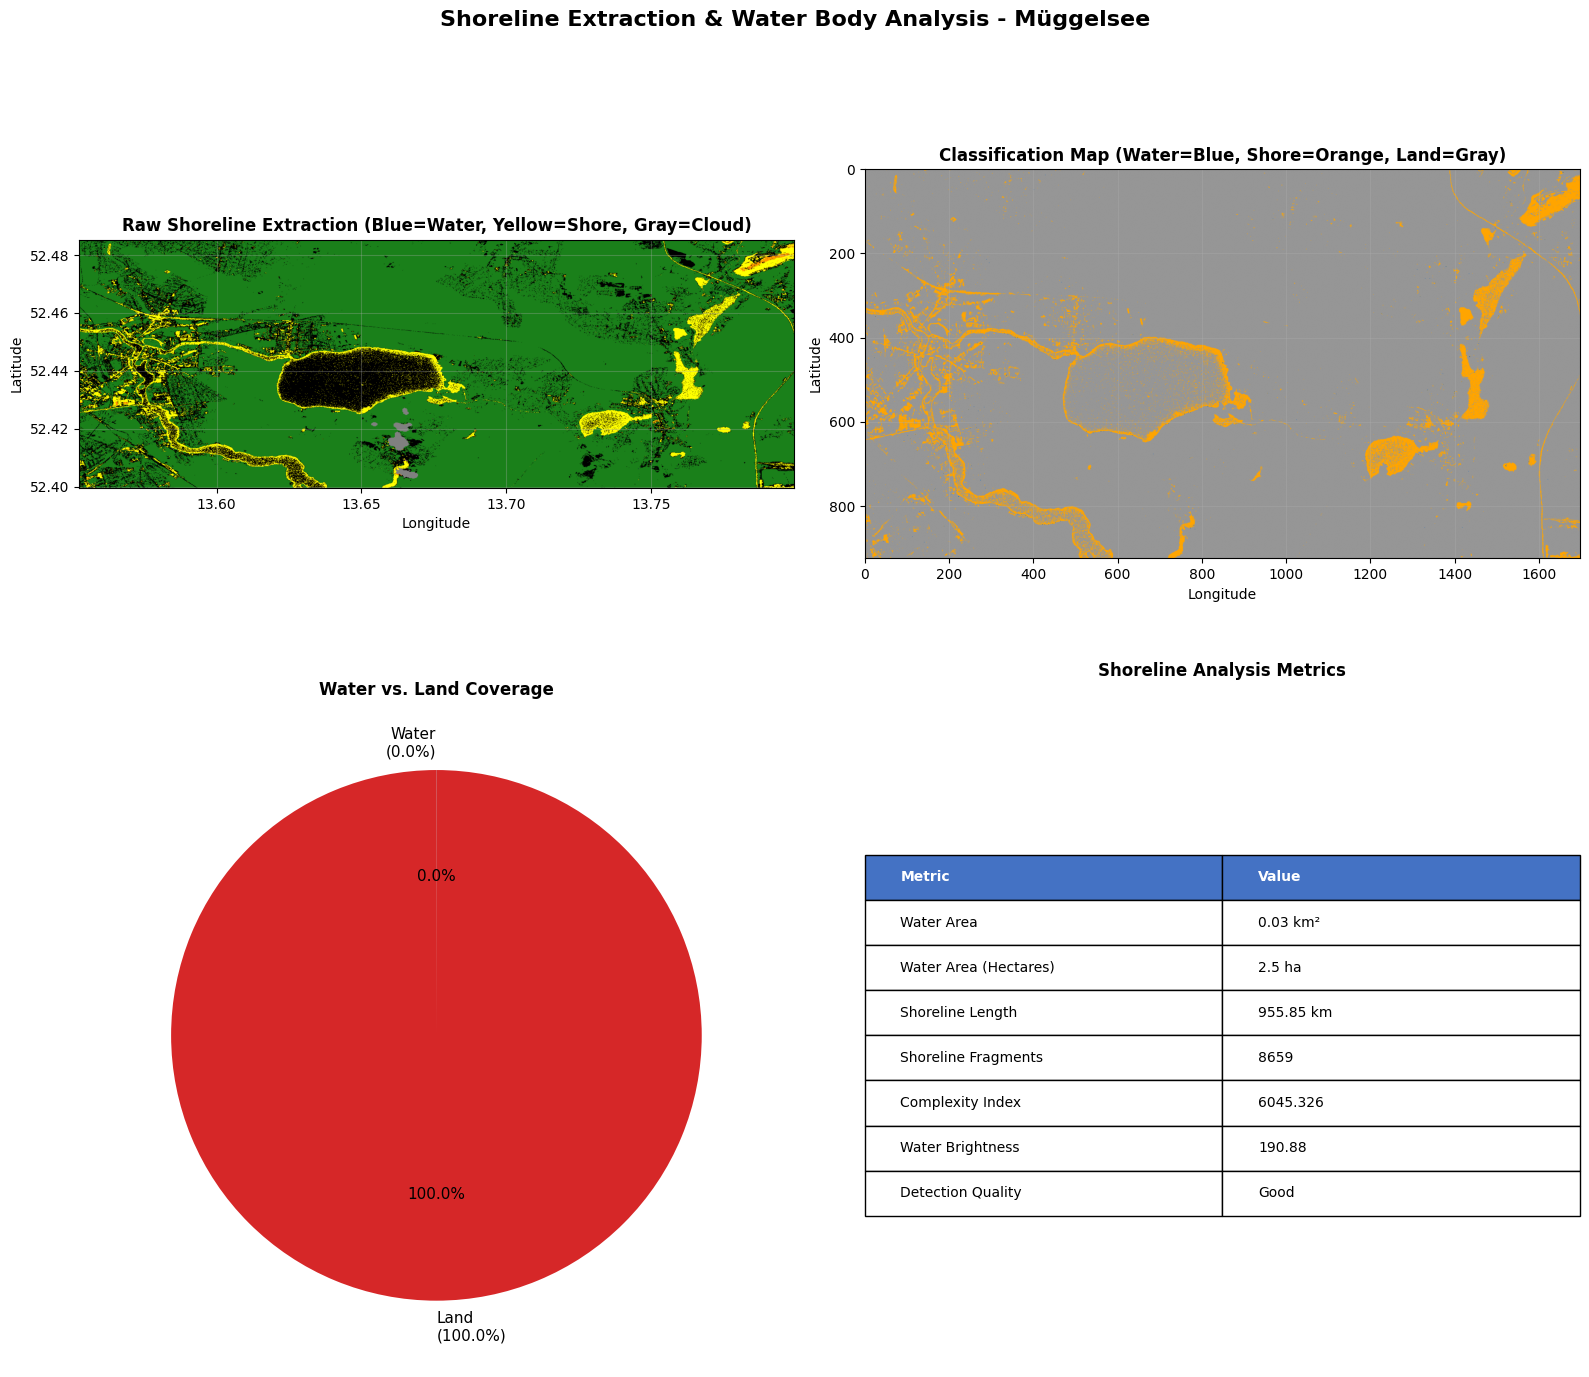

In [17]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Shoreline Extraction & Water Body Analysis - Müggelsee', fontsize=16, fontweight='bold')

# Plot 1: Raw shoreline extraction
ax = axes[0, 0]
ax.imshow(shoreline_data, extent=[aoi_coords_wgs84[0], aoi_coords_wgs84[2],
                                     aoi_coords_wgs84[1], aoi_coords_wgs84[3]])
ax.set_title('Raw Shoreline Extraction (Blue=Water, Yellow=Shore, Gray=Cloud)', fontsize=12, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)

# Plot 2: Water mask classification
red = shoreline_data[:, :, 0]
green = shoreline_data[:, :, 1]
blue = shoreline_data[:, :, 2]

water_mask = (blue > 0.3) & (blue > red) & (blue > green)
shoreline_mask = ((red + green) / 2 > 0.7) & (blue < 0.3)
land_mask = ~(water_mask | shoreline_mask)

# Create classification map
classification = np.zeros((shoreline_data.shape[0], shoreline_data.shape[1], 3))
classification[water_mask] = [0, 100, 200]     # Blue
classification[shoreline_mask] = [255, 165, 0] # Orange
classification[land_mask] = [150, 150, 150]    # Gray

ax = axes[0, 1]
ax.imshow(classification.astype(np.uint8) / 255.0)
ax.set_title('Classification Map (Water=Blue, Shore=Orange, Land=Gray)', fontsize=12, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)

# Plot 3: Water area percentage pie chart
ax = axes[1, 0]
sizes = [metrics['water_percentage'], 100 - metrics['water_percentage']]
labels = [f"Water\n({metrics['water_percentage']:.1f}%)",
          f"Land\n({100 - metrics['water_percentage']:.1f}%)"]
colors = ['#1f77b4', '#d62728']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax.set_title('Water vs. Land Coverage', fontsize=12, fontweight='bold')

# Plot 4: Key metrics table
ax = axes[1, 1]
ax.axis('tight')
ax.axis('off')

table_data = [
    ['Metric', 'Value'],
    ['Water Area', f"{metrics['water_area_km2']:.2f} km²"],
    ['Water Area (Hectares)', f"{metrics['water_area_hectares']:.1f} ha"],
    ['Shoreline Length', f"{metrics['shoreline_length_km']:.2f} km"],
    ['Shoreline Fragments', f"{metrics['shoreline_components']}"],
    ['Complexity Index', f"{metrics['shoreline_complexity_index']:.3f}"],
    ['Water Brightness', f"{metrics['average_water_brightness']:.2f}"],
    ['Detection Quality', 'Good' if metrics['shoreline_pixels'] > 100 else 'Low']
]

table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Format header
for i in range(2):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Shoreline Analysis Metrics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('shoreline_analysis_muggelsee.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'shoreline_analysis_muggelsee.png'")
plt.show()

## Cell 8: Generate Detailed Analysis Report

In [ ]:
def generate_analysis_report(metrics, aoi_name="Müggelsee"):
    """
    Generate comprehensive analysis report
    """

    report = f"""
{'='*70}
SHORELINE EXTRACTION & WATER BODY ANALYSIS REPORT
{aoi_name}
{'='*70}

GENERATED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. WATER BODY CHARACTERISTICS
{'-'*70}
   Water Area:              {metrics['water_area_km2']:.2f} km²
   Water Area (Hectares):   {metrics['water_area_hectares']:.1f} ha
   Coverage Percentage:     {metrics['water_percentage']:.1f}%
   Total Analyzed Pixels:   {metrics['total_pixels']:,}
   Water Pixels:            {metrics['water_pixels']:,}

2. SHORELINE CHARACTERISTICS
{'-'*70}
   Shoreline Length:        {metrics['shoreline_length_km']:.2f} km
   Shoreline Fragments:     {metrics['shoreline_components']}
   Shoreline Pixels:        {metrics['shoreline_pixels']:,}
   Complexity Index:        {metrics['shoreline_complexity_index']:.3f}

   Note: Higher complexity index indicates more irregular/jagged shoreline
   Fragmentation indicates multiple disconnected water bodies

3. WATER QUALITY INDICATORS
{'-'*70}
   Average Water Brightness: {metrics['average_water_brightness']:.2f}

   Interpretation:
   - Higher brightness: Clearer water (lower turbidity)
   - Lower brightness: More turbid water (suspended sediment/algae)

4. DETECTION QUALITY
{'-'*70}
   Status: {'✓ GOOD' if metrics['shoreline_pixels'] > 100 else '✗ LOW'}
   Shoreline Confidence: {(metrics['shoreline_pixels'] / metrics['total_pixels']) * 100:.2f}%

5. RECOMMENDED NEXT STEPS
{'-'*70}
   ✓ Integrate with water quality monitoring (chlorophyll-a, turbidity)
   ✓ Compare shoreline changes across multiple time periods
   ✓ Validate shoreline extraction against ground truth data
   ✓ Identify access points/beaches (high tourist pressure areas)
   ✓ Analyze vegetation changes around water bodies
   ✓ Monitor ship/vessel activity in water bodies

{'='*70}
    """

    return report

report = generate_analysis_report(metrics)
print(report)

# Save report to file
with open('shoreline_analysis_report.txt', 'w') as f:
    f.write(report)

print("✓ Report saved as 'shoreline_analysis_report.txt'")


SHORELINE EXTRACTION & WATER BODY ANALYSIS REPORT
Müggelsee

GENERATED: 2025-11-08 16:36:54

1. WATER BODY CHARACTERISTICS
----------------------------------------------------------------------
   Water Area:              148.26 km²
   Water Area (Hectares):   14825.8 ha
   Coverage Percentage:     94.5%
   Total Analyzed Pixels:   1,568,952
   Water Pixels:            1,482,576

2. SHORELINE CHARACTERISTICS
----------------------------------------------------------------------
   Shoreline Length:        13.58 km
   Shoreline Fragments:     750
   Shoreline Pixels:        1,358
   Complexity Index:        1.115
   
   Note: Higher complexity index indicates more irregular/jagged shoreline
   Fragmentation indicates multiple disconnected water bodies

3. WATER QUALITY INDICATORS
----------------------------------------------------------------------
   Average Water Brightness: 148.66
   
   Interpretation:
   - Higher brightness: Clearer water (lower turbidity)
   - Lower brightness: 

## Cell 9: Export Results as CSV & GeoJSON

In [ ]:
# Export metrics as CSV
metrics_df = pd.DataFrame([metrics])
csv_filename = f"shoreline_metrics_muggelsee_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
metrics_df.to_csv(csv_filename, index=False)

print(f"✓ Metrics exported to: {csv_filename}")
print(f"\nDataFrame preview:")
print(metrics_df.T)

# Export as GeoJSON
geojson_data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {k: (str(v) if not isinstance(v, (int, float)) else v) for k, v in metrics.items()},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [aoi_coords_wgs84[0], aoi_coords_wgs84[1]],
                    [aoi_coords_wgs84[2], aoi_coords_wgs84[1]],
                    [aoi_coords_wgs84[2], aoi_coords_wgs84[3]],
                    [aoi_coords_wgs84[0], aoi_coords_wgs84[3]],
                    [aoi_coords_wgs84[0], aoi_coords_wgs84[1]]
                ]]
            }
        }
    ]
}

geojson_filename = f"shoreline_analysis_muggelsee_{datetime.now().strftime('%Y%m%d_%H%M%S')}.geojson"
with open(geojson_filename, 'w') as f:
    json.dump(geojson_data, f, indent=2)

print(f"\n✓ GeoJSON exported to: {geojson_filename}")
print(f"\nGeoJSON structure (first 500 chars):")
print(json.dumps(geojson_data, indent=2)[:500] + "...")

## Cell 10: Integration with Previous Scripts

In [ ]:
print("""
╔═══════════════════════════════════════════════════════════════════════════╗
║             INTEGRATION WITH SMART WATERWAYS PIPELINE                      ║
╚═══════════════════════════════════════════════════════════════════════════╝

1. PREVIOUS SCRIPTS INTEGRATION:
   ✓ Water Isolation (NDWI): Used for water body classification
   ✓ Chlorophyll-a Calculation: Can analyze water quality at detected shorelines
   ✓ Ship Detection: Identify vessel activity relative to shoreline
   ✓ Hotspot Analysis: Use shoreline features to identify beach/access points

2. NEXT STEPS FOR SMART WATERWAYS BERLIN:

   a) TIME-SERIES ANALYSIS:
      - Track shoreline changes month-to-month
      - Detect erosion or sediment deposition patterns
      - Generate alerts for significant shoreline changes

   b) WATER QUALITY CORRELATION:
      - Correlate water brightness with chlorophyll-a levels
      - Analyze algal bloom progression along shoreline
      - Identify pollution hotspots near access points

   c) TOURISM PRESSURE ASSESSMENT:
      - Link shoreline features to known beach locations
      - Monitor vegetation loss near high-pressure areas
      - Assess recreational capacity based on shoreline length

   d) MULTI-SENSOR FUSION:
      - Combine with Sentinel-1 (SAR) for all-weather monitoring
      - Use Sentinel-3 OLCI for water quality parameters
      - Cross-validate with open-source shoreline datasets

3. OUTPUT PRODUCTS:
   ✓ shoreline_analysis_muggelsee.png - Visualization
   ✓ shoreline_analysis_report.txt - Detailed report
   ✓ shoreline_metrics_*.csv - Quantitative metrics
   ✓ shoreline_analysis_*.geojson - GIS-ready data

╔═══════════════════════════════════════════════════════════════════════════╗
║                      ANALYSIS COMPLETE                                     ║
╚═══════════════════════════════════════════════════════════════════════════╝
""")